<a href="https://colab.research.google.com/github/kupaqu/superdarn-nn/blob/main/10mar_superdarn_nn_pwr0_conv_cvw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
from datetime import datetime, timedelta
import random
import tensorflow as tf

In [ ]:
class DataLoader:
    def __init__(self,
                 datapath,
                 shuffle=True):
        self.shuffle = shuffle
        self.data = {}

        for root, _, files in os.walk(datapath):
            for name in files:
                filename = name.split('.')
                arr = np.load(os.path.join(root, name))
                self.data[filename[0] + filename[1][:2]] = arr

    def __iter__(self):
        target_datetime = list(self.data.keys())
        if self.shuffle:
            random.shuffle(target_datetime)

        # итерация по ключам в словаре self.data, где ключи – название файла
        for key in target_datetime:
            
            seq = self.__getSequence(key)
            arrays = []
            badCount = 0

            # итерация по историческим данным
            for item in seq:
                # некоторые исторические данные могут отсутствовать
                try:
                    arrays.append(self.data[item])
                except KeyError:
                    badCount += 1
            
            # если есть пропуски, то пропускаем пример
            if badCount != 0:
                continue
            else:
                x = np.concatenate(arrays, axis=1)
                y = self.data[key]
                yield x, y

    def __getSequence(self, key):
        filename_datetime = datetime.strptime(key, '%Y%m%d%H')

        # список массивов за день до целевого массива
        dayBefore = []
        for i in range(24, 0, -2):
            hoursBefore = (filename_datetime-timedelta(hours=i)).strftime('%Y%m%d%H')
            dayBefore.append(hoursBefore)

        # тот же час, но за неделю до целевого массива
        weekBeforeInThatHour = []
        for i in range(7, 0, -1):
            thatHour = (filename_datetime-timedelta(days=i)).strftime('%Y%m%d%H')
            weekBeforeInThatHour.append(thatHour)

        return dayBefore + weekBeforeInThatHour

        # список массивов за неделю до целевого массива
        # weekBefore = []
        # for i in range(24*7, 0, -2):
        #     hoursBefore = (filename_datetime-timedelta(hours=i)).strftime('%Y%m%d%H')
        #     weekBefore.append(hoursBefore)
        
        # return weekBefore

In [ ]:
batch_size = 1

train_loader = DataLoader('drive/MyDrive/2018-train')
val_loader = DataLoader('drive/MyDrive/2018-val')

train_dataset = tf.data.Dataset.from_generator(train_loader, output_types=(tf.float64, tf.float64)).batch(batch_size)
val_dataset = tf.data.Dataset.from_generator(val_loader, output_types=(tf.float64, tf.float64)).batch(batch_size)

In [ ]:
# генератор
def get_generator(regularizer_lambda=1e-5):

    history = tf.keras.layers.Input(shape=(100, 5040, 1))

    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same',
        kernel_regularizer=tf.keras.regularizers.L2(regularizer_lambda)
    )(history)

    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(1, 7),
        dilation_rate=(1, 12*60),
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.L2(regularizer_lambda)
    )(x)

    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same',
    )(x)

    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(1, 12),
        dilation_rate=(1, 60),
        activation='relu',
    )(x)

    output = tf.keras.layers.Conv2D(
        filters=1,
        kernel_size=1,
        activation='linear'
    )(x)

    generator = tf.keras.models.Model(history, output, name='generator')

    return generator

# дискриминатор
def get_discriminator(regularizer_lambda=1e-5):

    history = tf.keras.layers.Input(shape=(100, 5040, 1))
    target = tf.keras.layers.Input(shape=(100, 60, 1))
    concat = tf.keras.layers.Concatenate(axis=2)([history, target])
    
    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same',
        kernel_regularizer=tf.keras.regularizers.L2(regularizer_lambda)
    )(concat)

    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(1, 7),
        dilation_rate=(1, 12*60),
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.L2(regularizer_lambda)
    )(x)

    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same',
    )(x)

    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(1, 13),
        dilation_rate=(1, 60),
        activation='relu',
    )(x)

    x = tf.keras.layers.Conv2D(
        filters=1,
        kernel_size=(70, 1),
        activation='sigmoid'
    )(x)

    output = tf.keras.layers.Flatten()(x)
    
    discriminator = tf.keras.models.Model([history, target], output, name='discriminator')

    return discriminator

In [ ]:
class RadarGAN(tf.keras.Model):
    def __init__(self, discriminator, generator):
        super(RadarGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")
        self.gen_mae_tracker = tf.keras.metrics.Mean(name="generator_mae")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker, self.gen_mae_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(RadarGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.mae = tf.keras.losses.MeanAbsoluteError()

    def train_step(self, data):

        # класс 1 - настоящие данные, класс 0 - дискриминированные данные
        x, y = data
        x_shape = tf.shape(x)
        y_shape = tf.shape(y)

        # обучение дискриминатора
        for step in range(1):
            
            # маска по Бернулли
            p = tf.constant([0.8])
            r = tf.random.uniform(shape=x_shape, maxval=1)
            b = tf.math.greater(p, r)
            f = tf.cast(b, dtype=tf.dtypes.float64)

            # выход генератора
            generated = tf.cast(self.generator(tf.math.multiply(x, f)), dtype=tf.dtypes.float64)

            with tf.GradientTape() as tape:
                real = self.discriminator([x, y])
                fake = self.discriminator([x, generated])
                
                # значения потерь на чистых данных
                loss_on_real = self.loss_fn(tf.ones_like(real), real)
                loss_on_fake = self.loss_fn(tf.zeros_like(fake), fake)
                
                # целевое значение дискриминатора
                real_mixed = tf.math.round(tf.random.uniform(shape=(y_shape[0], y_shape[2]), minval=0, maxval=1, dtype=tf.dtypes.float64))

                # маска для реальных данных
                real_mask_mixed = tf.reshape(real_mixed, shape=(y_shape[0], 1, y_shape[2], 1))
                real_mask_mixed = tf.repeat(real_mask_mixed, repeats=y_shape[1], axis=1)
                real_mask_mixed = tf.repeat(real_mask_mixed, repeats=y_shape[3], axis=3)
                # маска для фейковых данных
                fake_mask_mixed = tf.math.subtract(tf.ones(shape=tf.shape(real_mask_mixed), dtype=tf.dtypes.float64), real_mask_mixed)

                # перемешивание данных
                mixed = tf.math.add(tf.math.multiply(real_mask_mixed, y), tf.math.multiply(fake_mask_mixed, generated))

                predictions = self.discriminator([x, mixed])

                loss_on_mixed = self.loss_fn(real, predictions)

                d_loss = loss_on_real + loss_on_fake + loss_on_mixed

            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
        
        # таргет генератора как выход дискриминатора
        g_target = tf.ones(shape=tf.shape(real), dtype=tf.dtypes.float64)

        # тренировка генератора
        for step in range(1):
            with tf.GradientTape() as tape:

                # Бернулли
                p = tf.constant([0.8])
                r = tf.random.uniform(shape=x_shape, maxval=1)
                b = tf.math.greater(p, r)
                f = tf.cast(b, dtype=tf.dtypes.float64)

                generated = tf.cast(self.generator(tf.math.multiply(x, f)), dtype=tf.dtypes.float64)

                discriminated = self.discriminator([x, generated])
                g_loss = self.loss_fn(g_target, discriminated)
                g_mae = self.mae(y, generated)
                
            grads = tape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.gen_mae_tracker.update_state(g_mae)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "g_mae": self.gen_mae_tracker.result()
            }

    def test_step(self, data):
        # Unpack the data
        x, y = data
        y_shape = tf.shape(y)

        # Compute predictions
        generated = self.generator(x)
        real = self.discriminator([x, y], training=False)
        fake = self.discriminator([x, generated], training=False)

        # Compute losses
        g_target = tf.ones(shape=tf.shape(real), dtype=tf.dtypes.float64)
        g_loss = self.loss_fn(g_target, fake)
        g_mae = self.mae(y, generated)

        loss_on_real = self.loss_fn(tf.ones_like(real), real)
        loss_on_fake = self.loss_fn(tf.zeros_like(fake), fake)
        
        d_loss = loss_on_real + loss_on_fake

        # Update losses
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.gen_mae_tracker.update_state(g_mae)

        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "g_mae": self.gen_mae_tracker.result()
            }

In [ ]:
# если обучать с нуля
radar_gan = RadarGAN(discriminator=get_discriminator(), generator=get_generator())

# дообучение
# radar_gan = RadarGAN(discriminator=keras.models.load_model('drive/MyDrive/radargan_discriminator_new.hdf5'), generator=keras.models.load_model('drive/MyDrive/radargan_generator_new.hdf5'))

# графическое изображение структуры
tf.keras.utils.plot_model(radar_gan.generator, to_file='g.png', show_shapes=True)
tf.keras.utils.plot_model(radar_gan.discriminator, to_file='d.png', show_shapes=True)

radar_gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=tf.keras.losses.BinaryCrossentropy()
)

In [ ]:
radar_gan.generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100, 5040, 1)]    0         
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 5040, 32)     832       
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 720, 32)      7200      
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 720, 32)      25632     
                                                                 
 conv2d_8 (Conv2D)           (None, 100, 60, 32)       12320     
                                                                 
 conv2d_9 (Conv2D)           (None, 100, 60, 1)        33        
                                                                 
Total params: 46,017
Trainable params: 46,017
Non-trainab

In [ ]:
radar_gan.discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 5040,   0           []                               
                                1)]                                                               
                                                                                                  
 input_4 (InputLayer)           [(None, 100, 60, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 concatenate_1 (Concatenate)    (None, 100, 5100, 1  0           ['input_3[0][0]',                
                                )                                 'input_4[0][0]']    

In [ ]:
hist = radar_gan.fit(train_dataset, epochs=200, validation_data=val_dataset)

Epoch 1/200
8/8 [==============================] - 20s 3s/step - g_loss: 2.1960 - d_loss: 1.4026 - g_mae: 1.8423 - val_g_loss: 1.9202 - val_d_loss: 1.3016 - val_g_mae: 1.8227
Epoch 2/200
8/8 [==============================] - 20s 3s/step - g_loss: 2.0030 - d_loss: 1.4401 - g_mae: 1.8960 - val_g_loss: 1.3407 - val_d_loss: 1.3106 - val_g_mae: 1.5516
Epoch 3/200
8/8 [==============================] - 20s 3s/step - g_loss: 1.7140 - d_loss: 1.3418 - g_mae: 1.6759 - val_g_loss: 1.6609 - val_d_loss: 1.4277 - val_g_mae: 1.5711
Epoch 4/200
8/8 [==============================] - 20s 3s/step - g_loss: 2.3404 - d_loss: 1.6602 - g_mae: 1.9297 - val_g_loss: 1.1760 - val_d_loss: 2.6701 - val_g_mae: 3.1424
Epoch 5/200
8/8 [==============================] - 20s 3s/step - g_loss: 1.8931 - d_loss: 2.1845 - g_mae: 3.5330 - val_g_loss: 1.1427 - val_d_loss: 1.4504 - val_g_mae: 3.4625
Epoch 6/200
8/8 [==============================] - 20s 3s/step - g_loss: 0.6819 - d_loss: 2.1159 - g_mae: 2.4398 - val_g_loss

In [ ]:
radar_gan.generator.save('drive/MyDrive/radargan_generator_new.hdf5')
radar_gan.discriminator.save('drive/MyDrive/radargan_discriminator_new.hdf5')

In [ ]:
import matplotlib.pyplot as plt

def plot_output(gan, dataset, channel=0, n_examples=5):
    dataset = dataset.as_numpy_iterator()
    figure, axis = plt.subplots(4, n_examples)

    x, y = dataset.next()
    for i in range(n_examples):

        # шум
        # p = tf.constant([0.8])
        # r = tf.random.uniform(shape=tf.shape(x), maxval=1)
        # b = tf.math.greater(p, r)
        # f = tf.cast(b, dtype=tf.dtypes.float64)
        # x = tf.math.multiply(x, f)

        fake = radar_gan.generator.predict(x)
        d_real = radar_gan.discriminator.predict([x, y])
        d_fake = radar_gan.discriminator.predict([x, fake])

        axis[0, i].imshow(y[i, :, :, channel])
        axis[0, i].set_title("R")

        axis[1, i].imshow(fake[i, :, :, channel])
        axis[1, i].set_title("G")

        axis[2, i].imshow((y-fake)[i, :, :, channel])
        axis[2, i].set_title("R - G")

        axis[3, i].hist((y-fake)[i, :, :, channel])
        axis[2, i].set_title("R - G distr")

    plt.show()
    plt.hist

1/1 [==============================] - 0s 49ms/step


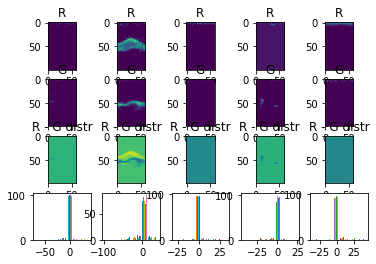

In [ ]:
plot_output(radar_gan, train_dataset)

In [ ]:
plot_output(radar_gan, val_dataset)

In [ ]:
for x, y in train_dataset:
    fake = radar_gan.generator.predict(x)
    print('real: ', radar_gan.discriminator.predict([x, y]))
    print('fake: ', radar_gan.discriminator.predict([x, fake]))
    break

In [ ]:
for x, y in train_dataset:
    plt.figure(figsize=(100, 100))
    plt.imshow(x[0,:,:,0])
    break

In [ ]:
plt.plot(hist.history['g_mae'])
plt.plot(hist.history['val_g_mae'])
plt.title('generator MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(hist.history['g_loss'])
plt.plot(hist.history['d_loss'])
plt.title('g and d training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'], loc='upper left')
plt.show()

In [ ]:
plt.plot(hist.history['val_g_loss'])
plt.plot(hist.history['val_d_loss'])
plt.title('g and d validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'], loc='upper left')
plt.show()